In [1]:
import glob
from glob import iglob
import os
import cv2
import time
import numpy as np
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from skimage.feature import hog
%matplotlib inline
from lesson_functions import *
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def load_data(root_dir):
    """
        Data is provided in the folders vehicles and non-vehicles
    """
    file_list = [f for f in iglob(root_dir, recursive=True) if os.path.isfile(f)]
    return file_list

## Load the Data
    Load the training data provided. 

No of car samples 8792
No of not car samples 8968


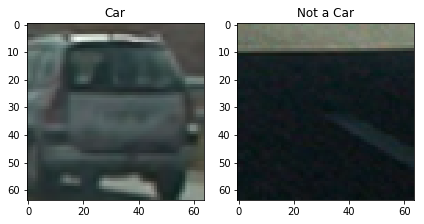

In [3]:
cars = load_data('./vehicles/**/*.png')
notcars = load_data('./non-vehicles/**/*.png')

print('No of car samples' , len(cars))
print('No of not car samples' , len(notcars))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

car_image = plt.imread(cars[0])
notcar_image = plt.imread(notcars[0])

ax1.imshow(car_image)
ax1.set_title("Car")

ax2.imshow(notcar_image)
ax2.set_title("Not a Car")

plt.tight_layout()

## Train the classifier
    The features are extracted from the input images. Spatial and histogram information is also used.
    The data is normalized using Standard Scaler from sklearn. The parameters are below

In [4]:
# Define parameters for feature extraction
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Car samples: ', len(car_features))
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('Notcar samples: ', len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC(loss='hinge') # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

Car samples:  8792
Notcar samples:  8968
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
3.31 Seconds to train SVC...
Test Accuracy of SVC =  0.9879


In [5]:
images = sorted(glob.glob('./test_images/test*.jpg'))
#images

## Hog Sub Sampling 
I have used Hog Subsampling provided with the lesson. The code is found in the lesson_functions.py. 
Changed to output rectangles along with image

## Find cars in the image.
    Tune the parameters to get the right region of interest.

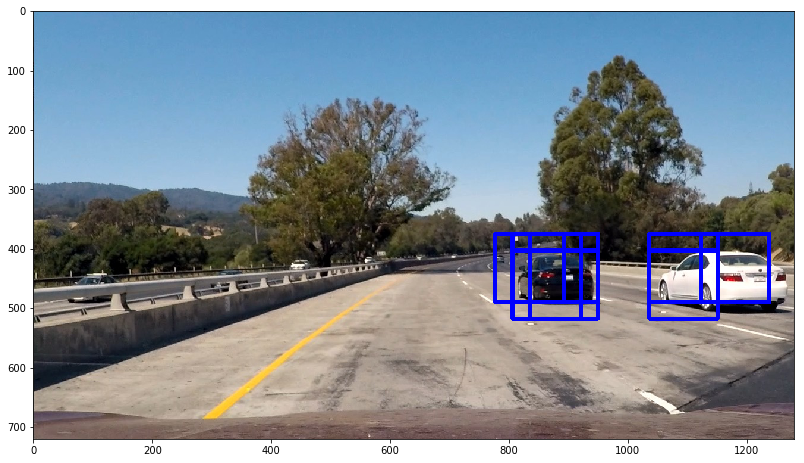

In [6]:
ystart = 375
ystop = 550
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

idx = 1
fig = plt.figure(figsize=(30,40))
scale = 1.8
# for file in images:
image= mpimg.imread('test_images/test1.jpg')
car_image,_ = find_cars(image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell, 
                        cell_per_block, spatial_size, hist_bins, False)
ax = fig.add_subplot(3,2,idx)
ax.imshow(car_image)
idx+=1

## Sampling the pipeline for multiple hits
 The parameters are tuned to get the right pipeline. To remove false hits.

Number of boxes:  184


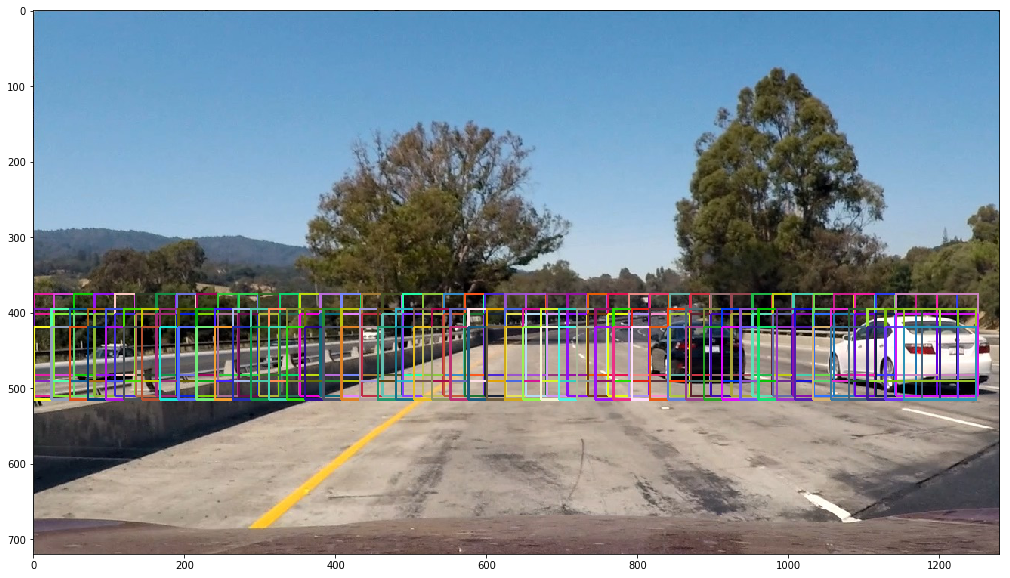

In [33]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 375
ystop = 550
scale = 1.7
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
rects.append(rect)
ystart = 395
ystop = 558
scale = 1.5
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
rects.append(rect)

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(30,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  16


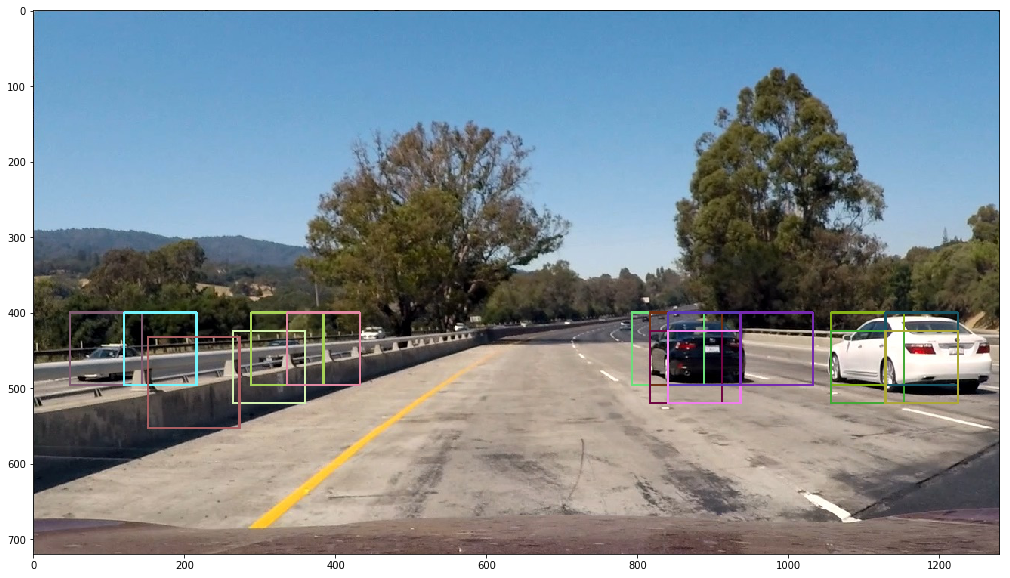

In [34]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 558
scale = 1.5
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)
ystart = 432
ystop = 588
scale = 1.9
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(30,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  64


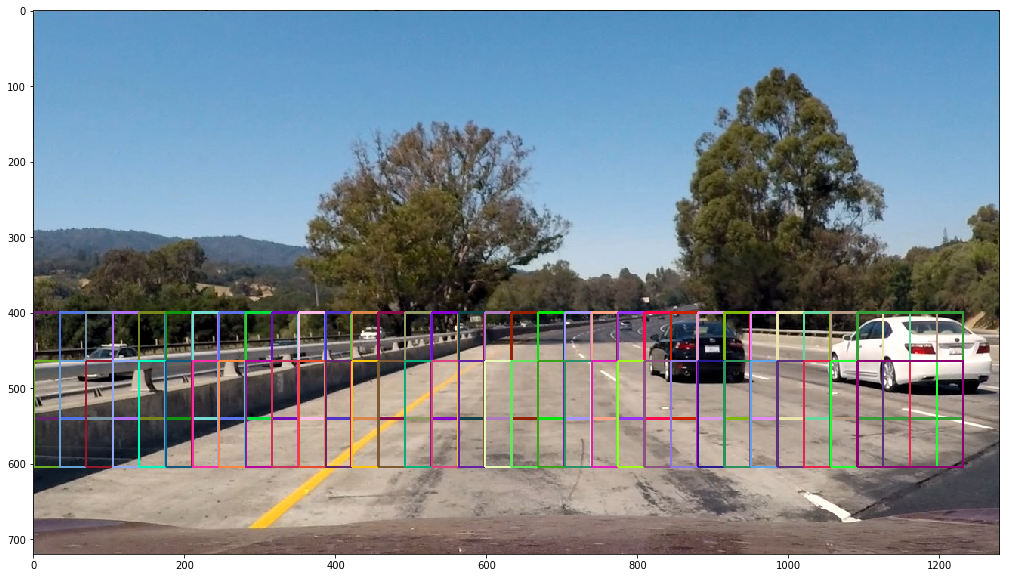

In [35]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 596
scale = 2.2
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
rects.append(rect)
ystart = 464
ystop = 660
scale = 2.2
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
rects.append(rect)

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(30,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  31
Number of boxes:  2
...


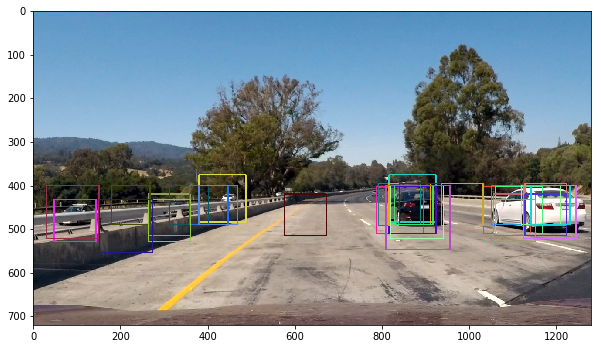

In [37]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 375
ystop = 550
scale = 1.7
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)
ystart = 395
ystop = 558
scale = 1.5
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)

ystart = 400
ystop = 520
scale = 1.4
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)
ystart = 432
ystop = 558
scale = 1.5
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)

ystart = 400
ystop = 558
scale = 1.9
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)
ystart = 432
ystop = 588
scale = 1.9
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)

ystart = 400
ystop = 596
scale = 2.3
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)
ystart = 464
ystop = 660
scale = 2.2
img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
rects.append(rect)

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rects for item in sublist] 
print('Number of boxes: ', len(rectangles))
print('Number of boxes: ', len(rectangles[0]))
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('...')

...


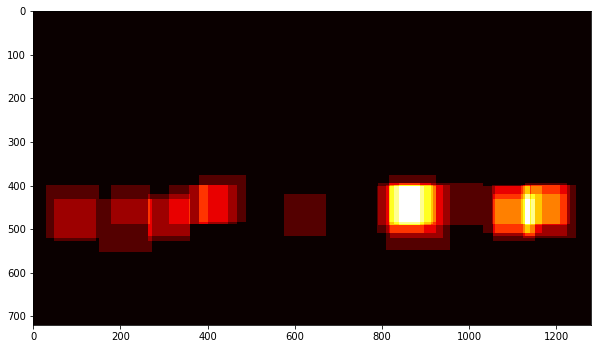

In [41]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

...


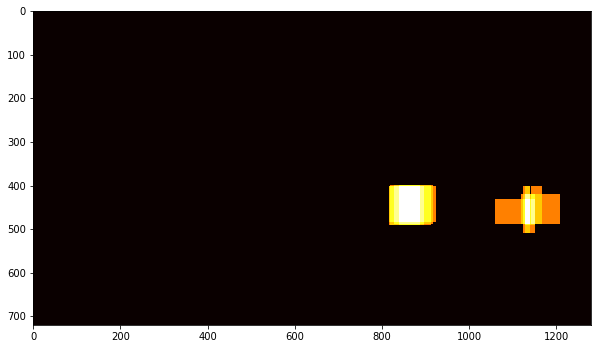

In [42]:
heatmap_img = apply_threshold(heatmap_img, 4)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

print('...')

2 cars found


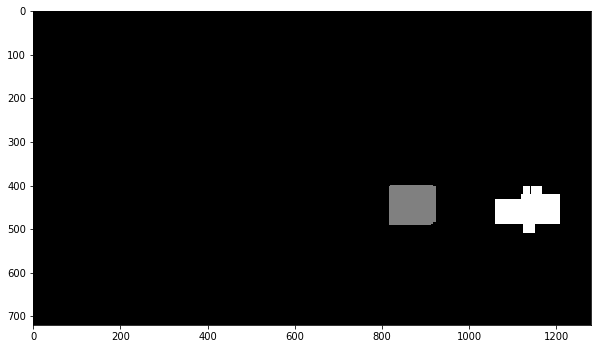

In [43]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

...


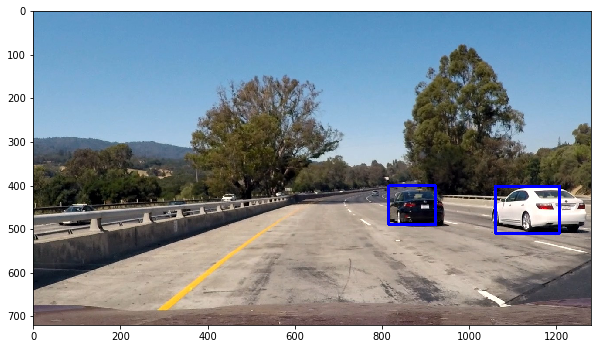

In [46]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
print('...')

In [44]:
def process_frame(img):

    rects = []
    
    color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    spatial_size = (16, 16)
    hist_bins = 32
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_feat = True
    hist_feat = True
    hog_feat = True

    # color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    #orient = 11
    #pix_per_cell = 16
    #cell_per_block = 2
    #hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 375
    ystop = 550
    scale = 1.7
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 395
    ystop = 558
    scale = 1.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    ystart = 400
    ystop = 520
    scale = 1.4
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 432
    ystop = 558
    scale = 1.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    ystart = 400
    ystop = 558
    scale = 1.9
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 432
    ystop = 588
    scale = 1.9
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    ystart = 400
    ystop = 596
    scale = 2.3
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 464
    ystop = 660
    scale = 2.2
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 400
    ystop = 596
    scale = 3.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 464
    ystop = 660
    scale = 3.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    rectangles = [item for sublist in rects for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('...')

...


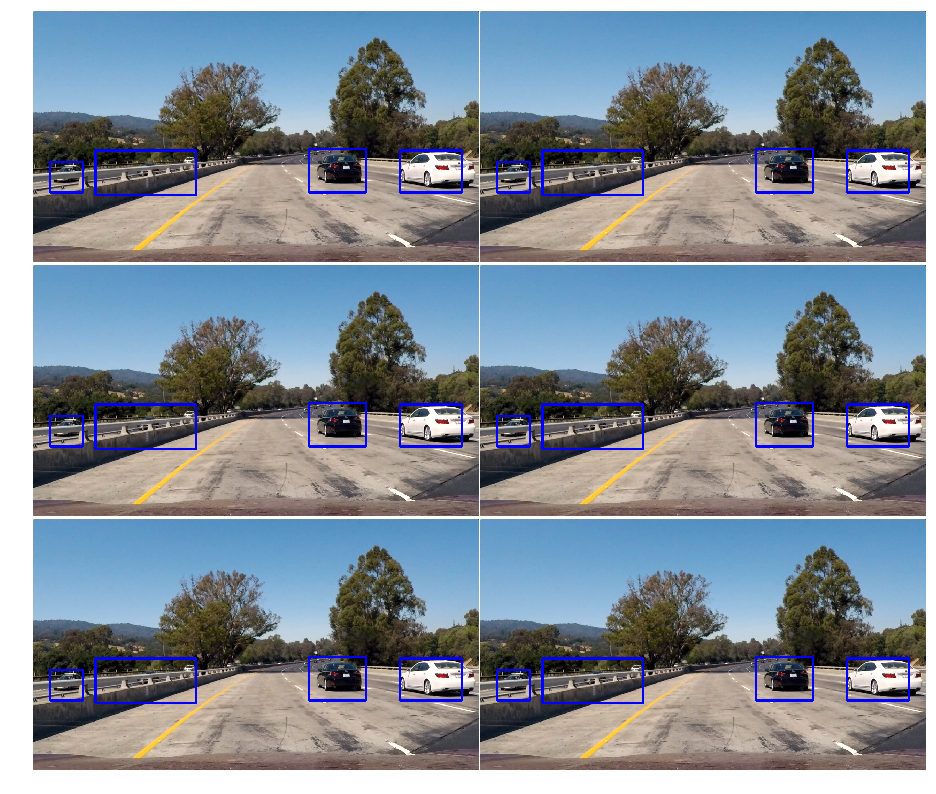

In [47]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

In [48]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

print('...')

...


In [49]:
def process_frame_for_video(img):

    rects = []
    
    color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    spatial_size = (16, 16)
    hist_bins = 32
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_feat = True
    hist_feat = True
    hog_feat = True

    # color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    #orient = 11
    #pix_per_cell = 16
    #cell_per_block = 2
    #hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    
    ystart = 375
    ystop = 550
    scale = 1.7
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 395
    ystop = 558
    scale = 1.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    ystart = 400
    ystop = 520
    scale = 1.4
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 432
    ystop = 558
    scale = 1.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    ystart = 400
    ystop = 558
    scale = 1.9
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 432
    ystop = 588
    scale = 1.9
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)

    ystart = 400
    ystop = 596
    scale = 2.3
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 464
    ystop = 660
    scale = 2.2
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 400
    ystop = 596
    scale = 3.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
    ystart = 464
    ystop = 660
    scale = 3.5
    img,rect = find_cars(test_img, ystart, ystop, scale, color_space, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, False)
    rects.append(rect)
 
    rectangles = [item for sublist in rects for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('...')

...


In [50]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [15:08<00:00,  1.49it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 15min 20s, sys: 37.4 s, total: 15min 57s
Wall time: 15min 8s
